In [1]:
from shapely.geometry import Polygon, Point
import pointpats
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.strtree import STRtree
import numpy as np
from SimuSamp.new_funcs.load.SpatDat import SpatDat
import pandas as pd
from SimuSamp.new_funcs.compute.n_core_sampler import sample_n_cores

In [2]:
parent_filepath = "../../../../../Simulated WS Sampling/block_data"
sampleids = ["01_F", "01_G", "02_G", "02_H", "03_B", "03_H", "04_I", "04_N", "05_G", "05_I", "06_H", "07_K", "08_J", "09_E", "10_B", "11_E", "11_F", "12_M", "13_G", "14_I", "15_G", "16_B", "17_I", "18_E", "19_F", "21_I", "22_N", "23_B", "24_I", "25_M", "26_I", "27_H", "28_FSC", "29_L", "30_D"]

microns_per_pixel=0.22715
mm2_per_pixels2 = (microns_per_pixel / 1000) ** 2

r = 0.5 * 1000 / microns_per_pixel
n = 10

In [3]:
spatdat = SpatDat(sampleid="03_B", parent_filepath=parent_filepath)

In [5]:
cells = spatdat.subset_cells("extended_partition")
tum_cells = spatdat.subset_cells("tumour")
im_cells = spatdat.subset_cells("IM")
tum = spatdat.subset_annotation("tumour")
ext_partition = spatdat.subset_annotation("extended_partition")
im = spatdat.subset_annotation("IM")
outer_im = spatdat.subset_annotation("outer_IM")

In [6]:
pgon = tum
polygon = gpd.GeoDataFrame(geometry=[pgon])

In [7]:
def int_area(point, poly, r=0.2):

    intersection_area = point.buffer(r).intersection(poly).area
    core_area = np.pi * r**2

    fraction = intersection_area / core_area

    return fraction

In [8]:
# Generates random points inside polygon
random_points = spatdat.poisson_distribution("tumour")

print(f"{len(random_points)} points calculated.")

1592 points calculated.


In [9]:
# Shuffle gdf for randomization
random_points = random_points.sample(frac=1).reset_index(drop=True)

point_list = []
tree = STRtree(point_list)
for idx, point in random_points.iterrows():
    if not any(tree.query(point.geometry, predicate="dwithin", distance=2*r)):
        
        # Evaluate core eligibility
        fraction = int_area(point.geometry, pgon, r)
        
        if fraction >= 0.5:
            point_list.append(point.geometry)
            tree = STRtree(point_list)

In [10]:
filtered_gdf = gpd.GeoDataFrame(geometry=point_list)
filtered_gdf = filtered_gdf.drop(0, axis=0) # Drop initial point
filtered_gdf_buffer = filtered_gdf.buffer(r)

n_samples = min([n, int(len(filtered_gdf_buffer))])

sampled_gdf = filtered_gdf_buffer.sample(n_samples)

n_sampled = len(sampled_gdf)

n_cores_sampled:  10


<Axes: >

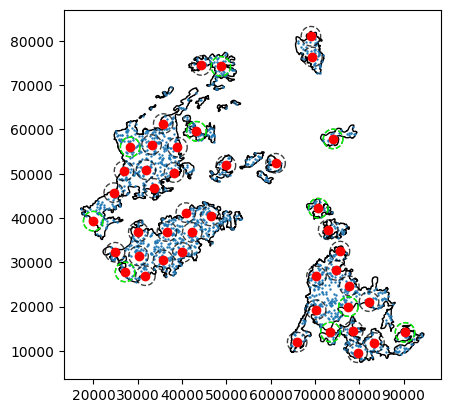

In [11]:
print("n_cores_sampled: ", n_sampled)
polygon.plot(color="None")
random_points.plot(ax=plt.gca(), markersize=0.5)
filtered_gdf.plot(ax=plt.gca(), color="red")
filtered_gdf_buffer.plot(ax=plt.gca(), color="None", edgecolor="black", alpha=0.75, linestyle="--")
sampled_gdf.plot(ax=plt.gca(), color="None", edgecolor="lime", linestyle="--")

In [14]:
cores = sampled_gdf.reset_index(drop=True)

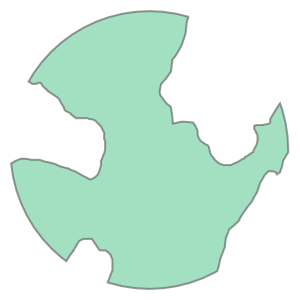

In [20]:
core = cores.geometry[5].intersection(ext_partition)
core

In [21]:
core_gdf = gpd.GeoDataFrame(geometry=[core])
core_cells = gpd.sjoin(cells, core_gdf, predicate="within")

In [22]:
random_points = pointpats.random.poisson(core, size=len(core_cells))
random_points = [Point(p) for p in random_points]
random_gdf = gpd.GeoDataFrame(geometry=random_points)

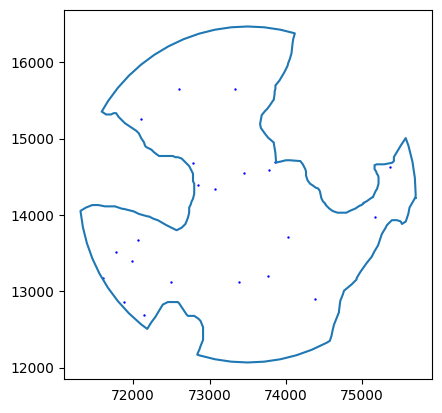

In [23]:
random_gdf.plot(color="blue", markersize=0.5)
plt.plot(*core.exterior.xy)

In [4]:
res = sample_n_cores(spatdat, n_core_list=[1, 2, 3], iterations=100)

In [5]:
res.to_excel("sampled_cores.xlsx")